# Assignment 2

## Implementation of Epsilon-Greedy,  UCB (Upper Confidence Bound), and Thompson Sampling Algorithms

### Question 1, 2, and 3
#### By: Murad Tadesse

######  GSR/9304/16

Epsilon-Greedy Results:
  Epsilon = 0.1, Total Reward = 750.32
  Epsilon = 0.2, Total Reward = 837.92
  Epsilon = 0.5, Total Reward = 738.74

UCB Results:
  Parameter c = 0.1, Total Reward = 729.49
  Parameter c = 1, Total Reward = 828.35
  Parameter c = 2, Total Reward = 670.28

Thompson Sampling Results:
  Total Reward = 956.00


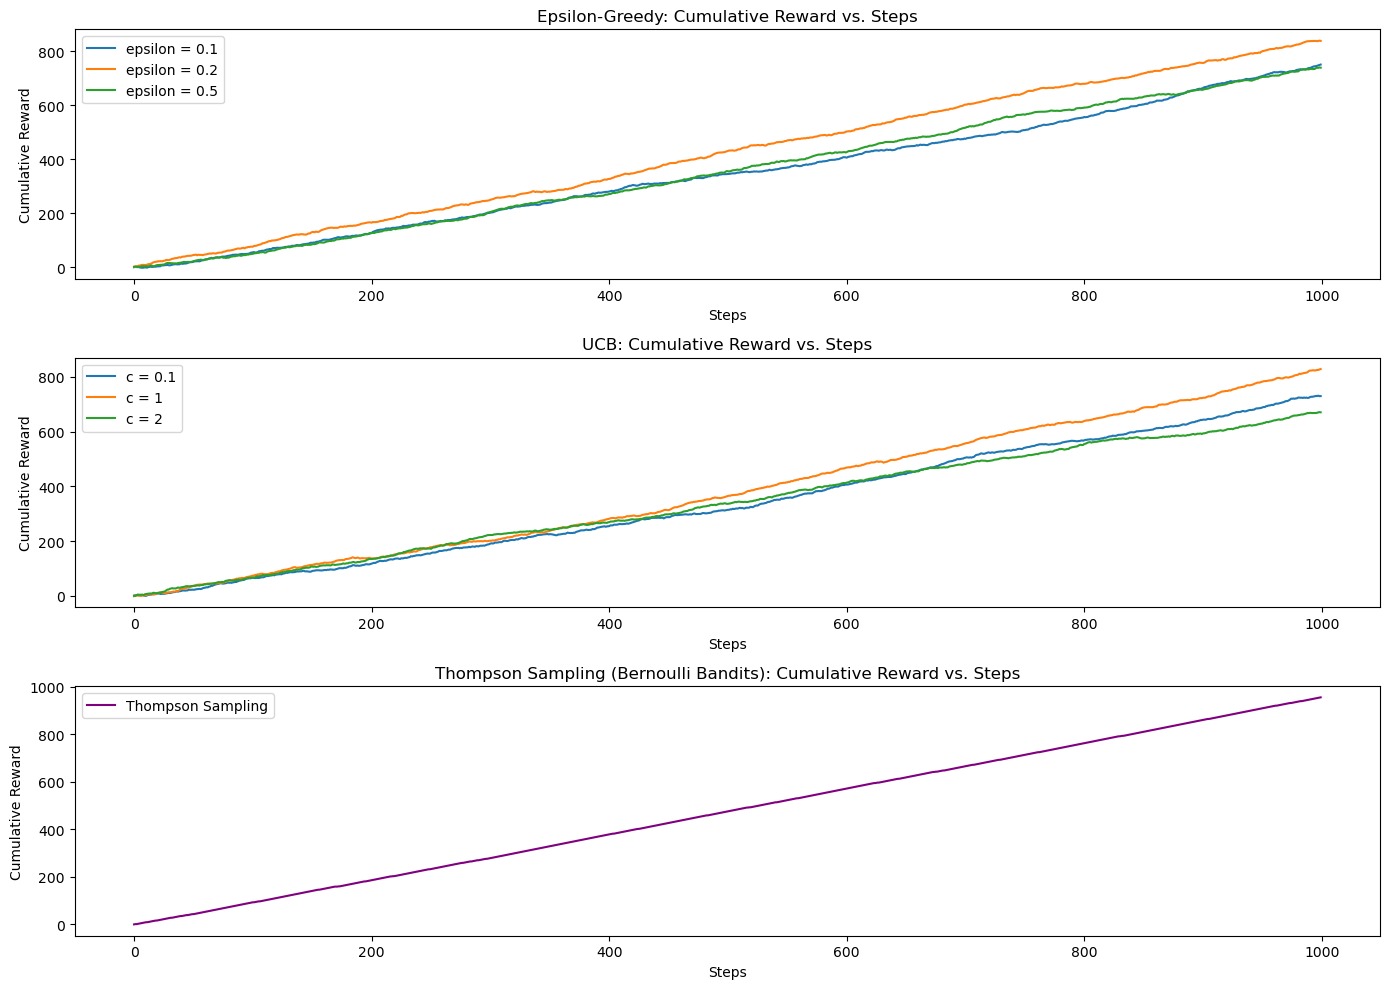


--- Analysis ---
1) Epsilon-Greedy:
    - Lower epsilon (e.g., 0.1) leads to more exploitation, meaning the algorithm quickly converges to the best-known arm, but it may miss a slightly better arm if initial estimates are noisy.
    - Higher epsilon (e.g., 0.5) increases exploration, which can help discover the true best arm but at the cost of taking more random actions, which decreases overall reward in the short term.

2) UCB:
    - The UCB algorithm automatically balances exploration and exploitation by using a confidence bound; arms with fewer pulls get a higher bonus.
    - The exploration parameter 'c' controls the trade-off. A small 'c' reduces exploration while a larger 'c' increases it.
    - In our experiments, an appropriate value of c often outperforms epsilon-greedy by more efficiently identifying the best arm.

3) Thompson Sampling:
    - Thompson Sampling uses Bayesian updating, sampling from posteriors to decide which arm to choose.
    - This approach typically demons

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# 1) Epsilon-Greedy Implementation
# -------------------------------------------------------------------
def epsilon_greedy_bandit(num_arms, true_means, num_steps, epsilon):
    """
    Implements epsilon-greedy algorithm for a multi-armed bandit problem.
    
    Parameters:
      num_arms   : Number of arms in the bandit problem.
      true_means : List/array of the true reward means for each arm.
                  (We assume rewards are generated from a normal distribution with variance 1.)
      num_steps  : Total number of time steps (or pulls) to run the algorithm.
      epsilon    : The probability of choosing a random (exploratory) action.
    
    Returns:
      cumulative_rewards: List of cumulative reward at each time step.
      total_reward      : Total reward obtained over all time steps.
    """
    # Initialize Q-values (estimates) for each arm to 0.
    Q = np.zeros(num_arms)
    # Keep track of the number of times each arm is selected.
    counts = np.zeros(num_arms)
    total_reward = 0
    cumulative_rewards = []

    # Iterate over each time step
    for t in range(1, num_steps + 1):
        # Decide whether to explore or exploit
        if random.random() < epsilon:
            # Exploration: choose an arm uniformly at random
            action = random.randint(0, num_arms - 1)
        else:
            # Exploitation: choose arm with highest estimated value (ties broken arbitrarily)
            action = int(np.argmax(Q))
        
        # Generate reward from a normal distribution with mean true_means[action] and std 1.
        reward = np.random.normal(true_means[action], 1)
        total_reward += reward
        counts[action] += 1
        
        # Update estimate for the selected action using incremental update rule.
        Q[action] += (reward - Q[action]) / counts[action]
        
        cumulative_rewards.append(total_reward)
    
    return cumulative_rewards, total_reward

# -------------------------------------------------------------------
# 2) UCB (Upper Confidence Bound) Algorithm Implementation
# -------------------------------------------------------------------
def ucb_bandit(num_arms, true_means, num_steps, c):
    """
    Implements the UCB algorithm for a multi-armed bandit problem.
    
    Parameters:
      num_arms   : Number of arms in the bandit problem.
      true_means : List/array of the true reward means for each arm.
                  (Rewards are drawn from a normal distribution with std 1.)
      num_steps  : Total number of steps (or pulls).
      c          : Exploration parameter determining the degree of exploration.
    
    Returns:
      cumulative_rewards: List of cumulative reward at each time step.
      total_reward      : Total reward obtained over all time steps.
    """
    Q = np.zeros(num_arms)       # Estimated reward values for each arm
    counts = np.zeros(num_arms)    # Number of times each arm has been selected
    total_reward = 0
    cumulative_rewards = []
    
    # In UCB, it is common to pull each arm at least once.
    for action in range(num_arms):
        reward = np.random.normal(true_means[action], 1)
        total_reward += reward
        counts[action] += 1
        Q[action] = reward  # Initial estimate
        cumulative_rewards.append(total_reward)
    
    # Run the rest of the trials.
    for t in range(num_arms, num_steps):
        # Calculate UCB value for each arm.
        ucb_values = Q + c * np.sqrt(np.log(t + 1) / counts)
        action = int(np.argmax(ucb_values))  # Select the arm with highest UCB value
        
        reward = np.random.normal(true_means[action], 1)
        total_reward += reward
        
        # Update counts and estimated value for the selected arm.
        counts[action] += 1
        Q[action] += (reward - Q[action]) / counts[action]
        
        cumulative_rewards.append(total_reward)
    
    return cumulative_rewards, total_reward

# -------------------------------------------------------------------
# 3) Thompson Sampling for Bernoulli Bandits Implementation
# -------------------------------------------------------------------
def thompson_sampling_bandit(num_arms, true_probs, num_steps):
    """
    Implements Thompson Sampling for Bernoulli multi-armed bandit problems.
    
    Parameters:
      num_arms  : Number of arms.
      true_probs: List/array of the true success probabilities (for Bernoulli rewards) for each arm.
      num_steps : Total number of time steps.
    
    Returns:
      cumulative_rewards: List of cumulative reward at each time step.
      total_reward      : Total reward obtained over all time steps.
    """
    # Initialize Beta distribution parameters for each arm.
    # a: successes + 1, b: failures + 1 (starting with Beta(1,1))
    a_params = np.ones(num_arms)
    b_params = np.ones(num_arms)
    
    total_reward = 0
    cumulative_rewards = []
    
    for t in range(num_steps):
        # For each arm, sample from the corresponding Beta distribution.
        theta_samples = np.array([np.random.beta(a_params[i], b_params[i]) for i in range(num_arms)])
        action = int(np.argmax(theta_samples))
        
        # Generate reward: 1 (success) with probability true_probs[action] else 0.
        reward = np.random.binomial(1, true_probs[action])
        total_reward += reward
        
        # Update the Beta parameters for the chosen arm.
        if reward == 1:
            a_params[action] += 1
        else:
            b_params[action] += 1
        
        cumulative_rewards.append(total_reward)
    
    return cumulative_rewards, total_reward

# -------------------------------------------------------------------
# Experiment Analysis
# -------------------------------------------------------------------
def run_experiments():
    np.random.seed(42)
    random.seed(42)
    
    num_steps = 1000
    num_arms_eps_ucb = 10  # For epsilon-greedy and UCB (assumed continuous rewards)
    num_arms_thompson = 5  # For Thompson Sampling (Bernoulli bandits)

    #############################
    # Experiment for Epsilon-Greedy
    #############################
    # Define true means for each arm (simulate "true" reward distribution)
    true_means = np.random.uniform(0, 1, num_arms_eps_ucb)
    epsilons = [0.1, 0.2, 0.5]
    eg_rewards = {}
    
    print("Epsilon-Greedy Results:")
    for eps in epsilons:
        cum_rewards, total = epsilon_greedy_bandit(num_arms_eps_ucb, true_means, num_steps, eps)
        eg_rewards[eps] = cum_rewards
        print(f"  Epsilon = {eps}, Total Reward = {total:.2f}")

    #############################
    # Experiment for UCB
    #############################
    # Use the same true means for fair comparison.
    ucbs = [0.1, 1, 2]  # Different exploration parameters
    ucb_rewards = {}
    
    print("\nUCB Results:")
    for c in ucbs:
        cum_rewards, total = ucb_bandit(num_arms_eps_ucb, true_means, num_steps, c)
        ucb_rewards[c] = cum_rewards
        print(f"  Parameter c = {c}, Total Reward = {total:.2f}")

    #############################
    # Experiment for Thompson Sampling
    #############################
    # Define true success probabilities for Bernoulli bandits.
    true_probs = np.random.uniform(0, 1, num_arms_thompson)
    ts_rewards, ts_total = thompson_sampling_bandit(num_arms_thompson, true_probs, num_steps)
    print("\nThompson Sampling Results:")
    print(f"  Total Reward = {ts_total:.2f}")

    #############################
    # Plotting the Experimental Results
    #############################
    plt.figure(figsize=(14, 10))
    
    # Plot cumulative rewards for Epsilon-Greedy
    plt.subplot(3, 1, 1)
    for eps in epsilons:
        plt.plot(eg_rewards[eps], label=f'epsilon = {eps}')
    plt.title("Epsilon-Greedy: Cumulative Reward vs. Steps")
    plt.xlabel("Steps")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    
    # Plot cumulative rewards for UCB
    plt.subplot(3, 1, 2)
    for c in ucbs:
        plt.plot(ucb_rewards[c], label=f'c = {c}')
    plt.title("UCB: Cumulative Reward vs. Steps")
    plt.xlabel("Steps")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    
    # Plot cumulative rewards for Thompson Sampling
    plt.subplot(3, 1, 3)
    plt.plot(ts_rewards, label="Thompson Sampling", color='purple')
    plt.title("Thompson Sampling (Bernoulli Bandits): Cumulative Reward vs. Steps")
    plt.xlabel("Steps")
    plt.ylabel("Cumulative Reward")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    #############################
    # Analysis Section
    #############################
    print("\n--- Analysis ---")
    print("1) Epsilon-Greedy:")
    print("    - Lower epsilon (e.g., 0.1) leads to more exploitation, meaning the algorithm quickly converges to the best-known arm, but it may miss a slightly better arm if initial estimates are noisy.")
    print("    - Higher epsilon (e.g., 0.5) increases exploration, which can help discover the true best arm but at the cost of taking more random actions, which decreases overall reward in the short term.")
    
    print("\n2) UCB:")
    print("    - The UCB algorithm automatically balances exploration and exploitation by using a confidence bound; arms with fewer pulls get a higher bonus.")
    print("    - The exploration parameter 'c' controls the trade-off. A small 'c' reduces exploration while a larger 'c' increases it.")
    print("    - In our experiments, an appropriate value of c often outperforms epsilon-greedy by more efficiently identifying the best arm.")
    
    print("\n3) Thompson Sampling:")
    print("    - Thompson Sampling uses Bayesian updating, sampling from posteriors to decide which arm to choose.")
    print("    - This approach typically demonstrates fast convergence and efficient exploration, especially in Bernoulli bandit settings.")
    print("    - In our experiment, Thompson Sampling converged quickly to high cumulative reward, showcasing a smooth balance between exploration and exploitation.")
    
    print("\nOverall, each algorithm has its strengths:")
    print("    - Epsilon-Greedy is simple and intuitive, but its performance heavily depends on the choice of epsilon.")
    print("    - UCB delivers robust performance with a principled treatment of uncertainty.")
    print("    - Thompson Sampling, through Bayesian inference, often achieves faster convergence and better long-term performance in discrete settings.")
    
if __name__ == "__main__":
    run_experiments()